# Enso Simulation / Scenario Analysis Framework

1) Data Cleaning ENSO and ADF/Stationarity test
2) Fitting ARIMA model (test for d)
3) Fourier Decomposition
4) Fit corresponding ARIMAX model with Fourier as exogenous
4) Create Forecast and Scenario's for next 5 years

## ENSO Timeseries Cleaning and Stationarity

In [16]:
import pandas as pd
import numpy as np
# Load the dataset
enso_df = pd.read_csv('../Data/enso_mei_long.csv')
# Display the first few rows of the dataframe and check for missing values
display(enso_df.tail(), enso_df.isnull().sum())
#remove NaN MEI rows
enso_df = enso_df.dropna()
enso_df.tail()


,Year,Month,MEI
535,2023,Aug,0.43
536,2023,Sep,0.59
537,2023,Oct,NaN
538,2023,Nov,NaN
539,2023,Dec,NaN


Year     0
Month    0
MEI      3
dtype: int64

,Year,Month,MEI
532,2023,May,-0.14
533,2023,Jun,0.23
534,2023,Jul,0.25
535,2023,Aug,0.43
536,2023,Sep,0.59


Adjust dataset to correct timeseries format

In [11]:
# Convert the 'Year' and 'Month' into a datetime object and set it as the index
enso_df['Date'] = pd.to_datetime(enso_df['Year'].astype(str) + ' ' + enso_df['Month'], format="%Y %b")
enso_df.set_index('Date', inplace=True)

# Drop the original 'Year' and 'Month' columns 
enso_df.drop(['Year', 'Month'], axis=1, inplace=True)

# Ensure the data is sorted in chronological order
enso_df.sort_index(inplace=True)
enso_df.index = pd.DatetimeIndex(enso_df.index.values, freq=enso_df.index.inferred_freq)

# Check the dataframe structure now
display(enso_df.head(), enso_df.tail())


,MEI
1979-01-01,0.47
1979-02-01,0.27
1979-03-01,-0.04
1979-04-01,0.26
1979-05-01,0.35


,MEI
2023-05-01,-0.14
2023-06-01,0.23
2023-07-01,0.25
2023-08-01,0.43
2023-09-01,0.59


Check ACF and PACF of timeseries

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Plot the Autocorrelation Function (ACF)
plot_acf(enso_df['MEI'], lags=50, ax=ax1, title= "Autocorrlation (ACF) of MEI.v2")
# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(enso_df['MEI'], lags=50, ax=ax2, title= "Partial Autocorrelation (PACF) of MEI.v2")
plt.savefig('../Plots/ACF_PACF.png')
plt.tight_layout()
plt.show()


- The ACF shows a slow decay, which indicates a non-stationary series or a series with long-term correlations.
- The PACF has a spike at lag 1 and lag 2, suggesting AR(1) or AR(2) model might be needed.
Since the series is normalized and stationary we do not need $d$ = 1, this means that we can look at models ARIMA(p,0,q) where 0 <= p,q <= 2 

## Fourier Decomposition

Fourier decomposition involves transforming the time series into the frequency domain using the Fourier Transform. This allows us to identify dominant cycles in the data which can be related to seasonal effects.

Apply the Fourier Transform to the MEI time series.
- Identify the dominant frequencies (which correspond to the strongest seasonal patterns).
- Use these dominant frequencies to construct a series of sine and cosine terms that model the seasonal pattern.
- These sine and cosine terms will later be used as exogenous variables in the ARIMAX model.

,Frequency,Amplitude
4,0.007449,153.864183
12,0.022346,133.572696
8,0.014898,116.754668
15,0.027933,99.788434
10,0.018622,99.419709
1,0.001862,93.567986
18,0.033520,89.675907
30,0.055866,81.549433
11,0.020484,75.180320
19,0.035382,49.670009


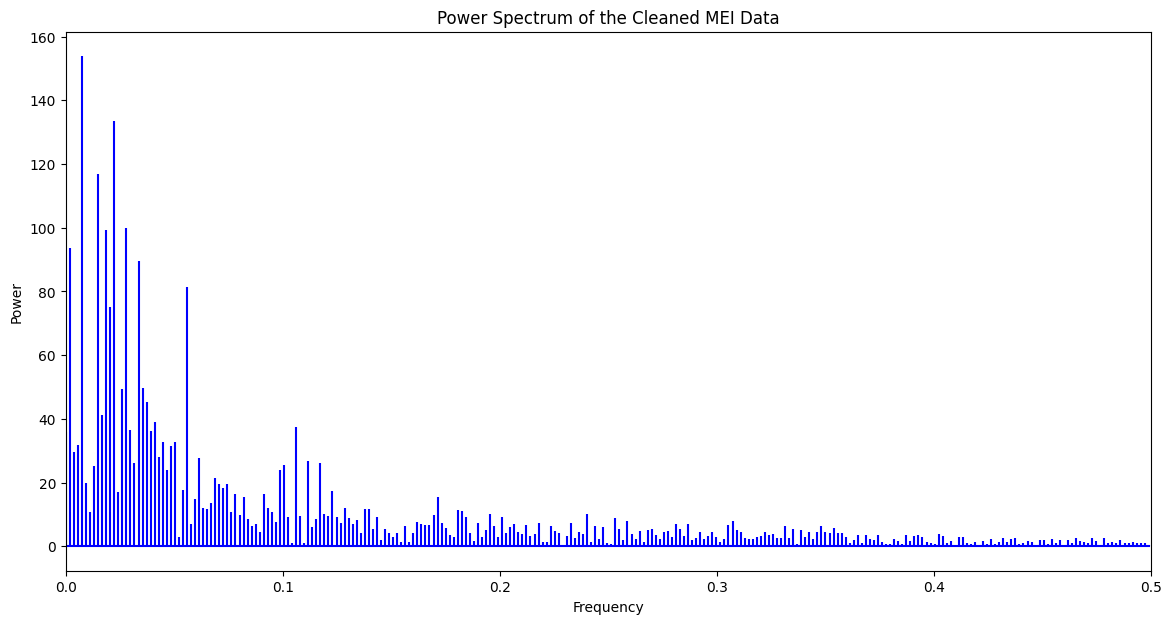

In [12]:
import numpy as np
from scipy.fft import rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
N = enso_df.shape[0]
T = 1.0  # assuming monthly data, so the unit is 'months'
# Compute the fast Fourier Transform (rfft) of the MEI time series
yf = rfft(enso_df['MEI'].values)
# Generate the sample frequencies
xf = rfftfreq(N, T)
# Create a dataframe of frequencies and their corresponding amplitudes
fft_df = pd.DataFrame({'Frequency': xf, 'Amplitude': np.abs(yf)})
fft_df_sorted = fft_df.sort_values(by='Amplitude', ascending=False)
# Display the dominant frequencies
display(fft_df_sorted.head(10))

spectrum = np.abs(yf)
plt.figure(figsize=(14, 7))
plt.stem(xf, spectrum, 'b', markerfmt=" ", basefmt="-b")
plt.title('Power Spectrum of the Cleaned MEI Data')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.xlim(0, 0.5)  # Only plot the positive frequencies
plt.savefig('../Plots/fft.png')
plt.show()

The power spectrum plot shows the various frequencies present in the ENSO data and their relative power. 

Peaks in this spectrum represent dominant frequencies that could correspond to seasonal or cyclical patterns.



Frequencies in cycles per month, we take a few with the highest amplitudes to construct the sine and cosine terms. We select top 5 frequencies to als not overfit.

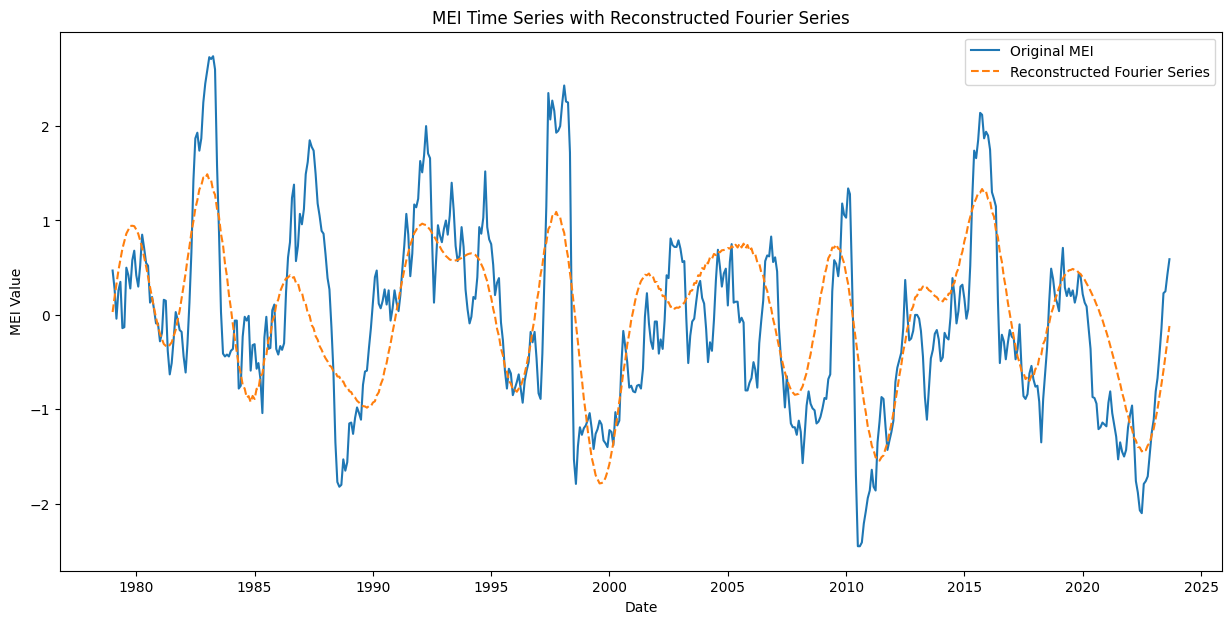

In [13]:
# Select the top 5 frequencies, No 0 since this is overall trend
top_frequencies = fft_df_sorted[fft_df_sorted['Frequency'] > 0].head(5)
top_indices = fft_df_sorted[fft_df_sorted['Frequency'] > 0].head(5).index

# Create a new series of Fourier coefficients where all but the top components are set to zero
filtered_fft_values = np.zeros_like(yf)
for i in top_indices:
    filtered_fft_values[i] = yf[i]
    filtered_fft_values[-i] = yf[-i]  # Include the complex conjugate for inverse FFT (imaginary numbers are mirrored and should be added)

# Perform the inverse FFT to reconstruct the time series using the top components/feqs
reconstructed_series = irfft(filtered_fft_values, n=N)

# Plot the original MEI time series and the reconstructed Fourier series
plt.figure(figsize=(15, 7))
plt.plot(enso_df.index, enso_df['MEI'], label='Original MEI')
plt.plot(enso_df.index, reconstructed_series, label='Reconstructed Fourier Series', linestyle='--')
plt.legend()
plt.title('MEI Time Series with Reconstructed Fourier Series')
plt.xlabel('Date')
plt.ylabel('MEI Value')
plt.savefig('../Plots/MEI_Fourier.png')
plt.show()

### Fourier Residuals

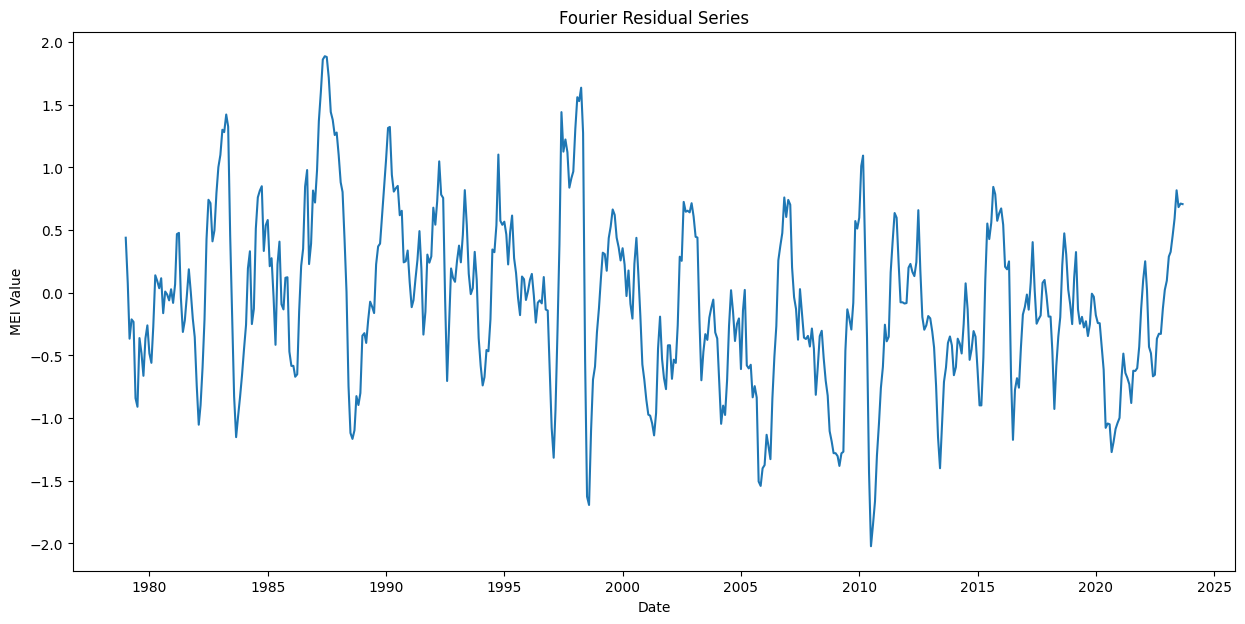

In [14]:
#Fourier residual plot
fourier_residuals = enso_df['MEI'] - reconstructed_series
#plot Fourier residual series
plt.figure(figsize=(15, 7))
plt.plot(enso_df.index, fourier_residuals)
plt.title('Fourier Residual Series')
plt.xlabel('Date')
plt.ylabel('MEI Value')
plt.savefig('../Plots/fourier_residuals.png')
plt.show()

## ARIMA(X) model fitting

The next steps are to:

- Fit an ARIMA model to the MEI data.
- Incorporate the sine and cosine terms as exogenous variables to fit an ARIMAX model.

### ARIMA Model selection
- Look at ACF and PACF
- Look at AIC and BIC

### ARIMA(1,0,0)

In [173]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model. We'll start with an ARIMA(1,0,0) model.
arima_model = ARIMA(enso_df['MEI'], order=(1, 0, 0))
arima_result = arima_model.fit()

# Display the summary of the ARIMA model
arima_result_summary = arima_result.summary()
arima_result_summary
# Plot the diagnostics for the ARIMA model
fig = arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -121.395
Date:                Wed, 08 Nov 2023   AIC                            248.790
Time:                        14:58:30   BIC                            261.648
Sample:                    01-01-1979   HQIC                           253.820
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0270      0.279     -0.097      0.923      -0.574       0.520
ar.L1          0.9504      0.013     70.408      0.000       0.924       0.977
sigma2         0.0916      0.003     26.732      0.000       0.085       0.098
===================================================================================
Ljung-Box (L1) (Q):                  81.86   Jarque-Bera (JB):               436.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.72
Prob(H) (two-sided):                  0.37   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- AR1 term significant
- Ljung-Box test indicates residuals are not independently distributed and there might still be an underlying pattern not captured.
- Jarque - Bera test also indicates not normal
- No signs of Heteroskedasticity

Extra resiudal check:

Note that heavy tails exist, they are standardized, J-B results show us indeed that the residuals ≠ normal.
ACF plot shows autocorrelations.

### ARIMA(1,0,1)


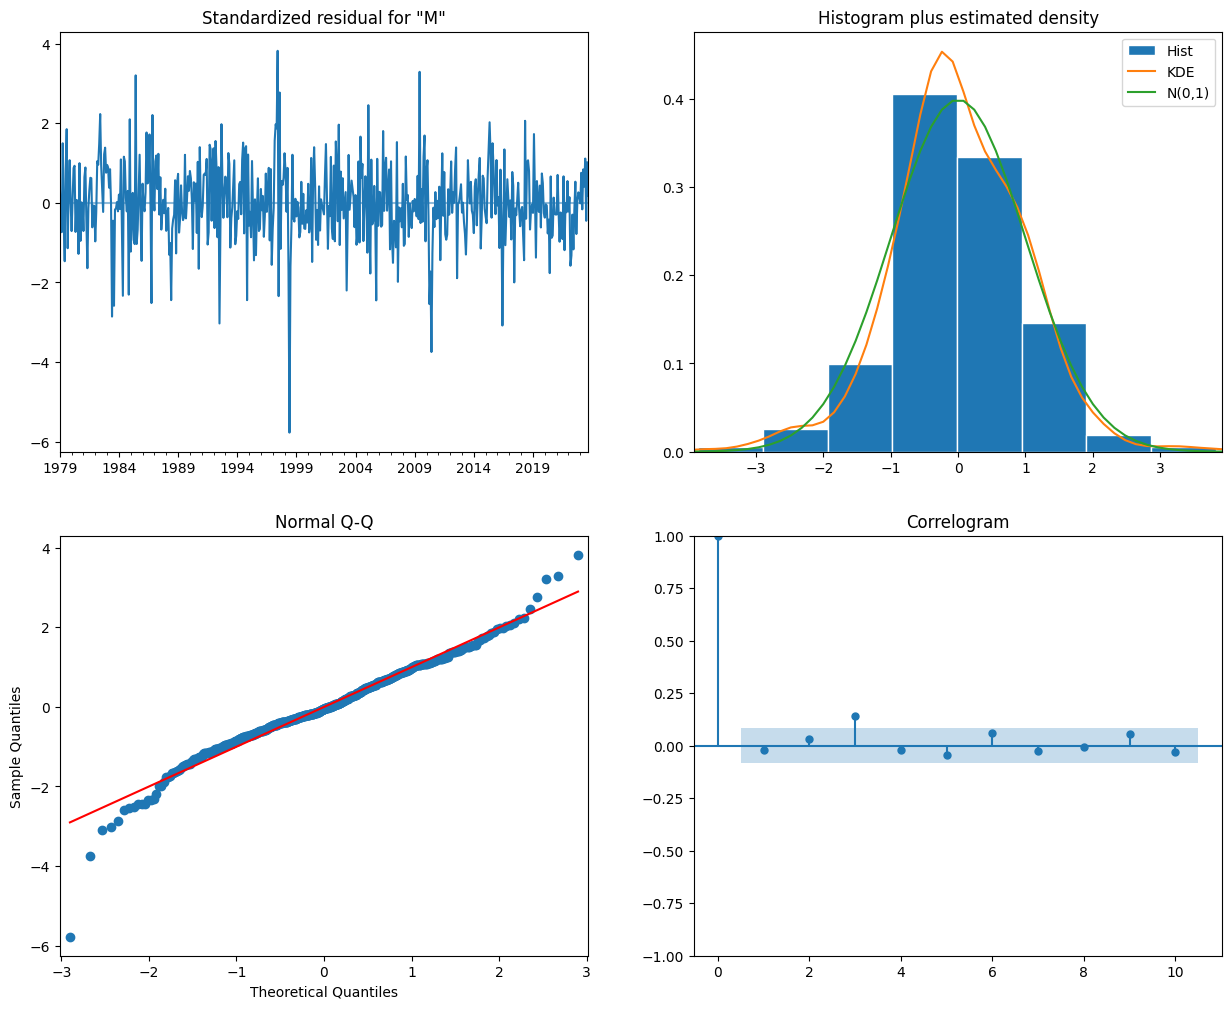

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -59.222
Date:                Wed, 08 Nov 2023   AIC                            126.444
Time:                        18:13:03   BIC                            143.588
Sample:                    01-01-1979   HQIC                           133.150
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0451      0.206     -0.218      0.827      -0.450       0.359
ar.L1          0.9075      0.018     50.042      0.000       0.872       0.943
ma.L1          0.5567      0.032     17.473      0.000       0.494       0.619
sigma2         0.0726      0.003     22.969      0.000       0.066       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               179.89
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.38
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [254]:
# Fit an ARIMA(1,0,1) model
arima_model_101 = ARIMA(enso_df['MEI'], order=(1, 0, 1))
arima_result_101 = arima_model_101.fit()

# Plot the diagnostics for the ARIMA(1,0,1) model
fig = arima_result_101.plot_diagnostics(figsize=(15, 12))
plt.savefig('../Plots/ARIMA_101.png')
plt.show()

# Return the summary of the new model as well
arima_result_101_summary = arima_result_101.summary()
display(arima_result_101_summary)

- AR1 and MA1 significant
- LL improved from -120 => -58
- AIC and BIC also decreased 247 -> 124
- L-B test suggest no significant autocorrelation and residuals independently distributed.
- J-B no normality within residuals. 
- ACF shows better behaviour than no MA1 component.  

### ARIMA(p,0,q) p <= 2 and q <= 2

In [175]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ARIMA orders we want to test
arima_orders = [(1,0,0), (0,0,1), (1,0,1),(2, 0, 1), (1, 0, 2), (2, 0, 2)]

# Initialize a dictionary to store results
arima_results = {}

# Fit the ARIMA models and store the results
for order in arima_orders:
    model = SARIMAX(enso_df['MEI'], order=order)
    results = model.fit()
    arima_results[order] = {
        'AIC': results.aic,
        'BIC': results.bic,
        'Log Likelihood': results.llf
    }

# Convert the results to a DataFrame for easy comparison
arima_results_df = pd.DataFrame(arima_results).T

# Identify the model with the lowest AIC and BIC
best_aic_model = arima_results_df['AIC'].idxmin()
best_bic_model = arima_results_df['BIC'].idxmin()
best_log_lik_model = arima_results_df['Log Likelihood'].idxmax()

arima_results_df, best_aic_model, best_bic_model, best_log_lik_model


 This problem is unconstrained.
/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26082D-01    |proj g|=  4.86368D-03

At iterate    5    f=  2.26081D-01    |proj g|=  4.57957D-03

At iterate   10    f=  2.26072D-01    |proj g|=  7.10440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   9.851D-06   2.261D-01
  F =  0.22607197094745651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

(              AIC         BIC  Log Likelihood
 1 0 0  246.801297  255.373293     -121.400648
 0 0 1  871.472711  880.044707     -433.736356
 1 0 1  124.498198  137.356192      -59.249099
 2 0 1  125.377609  142.521601      -58.688804
 1 0 2  125.717730  142.861723      -58.858865
 2 0 2  122.254145  143.684135      -56.127072,
 (2, 0, 2),
 (1, 0, 1),
 (2, 0, 2))

### ARIMA(2,0,2)

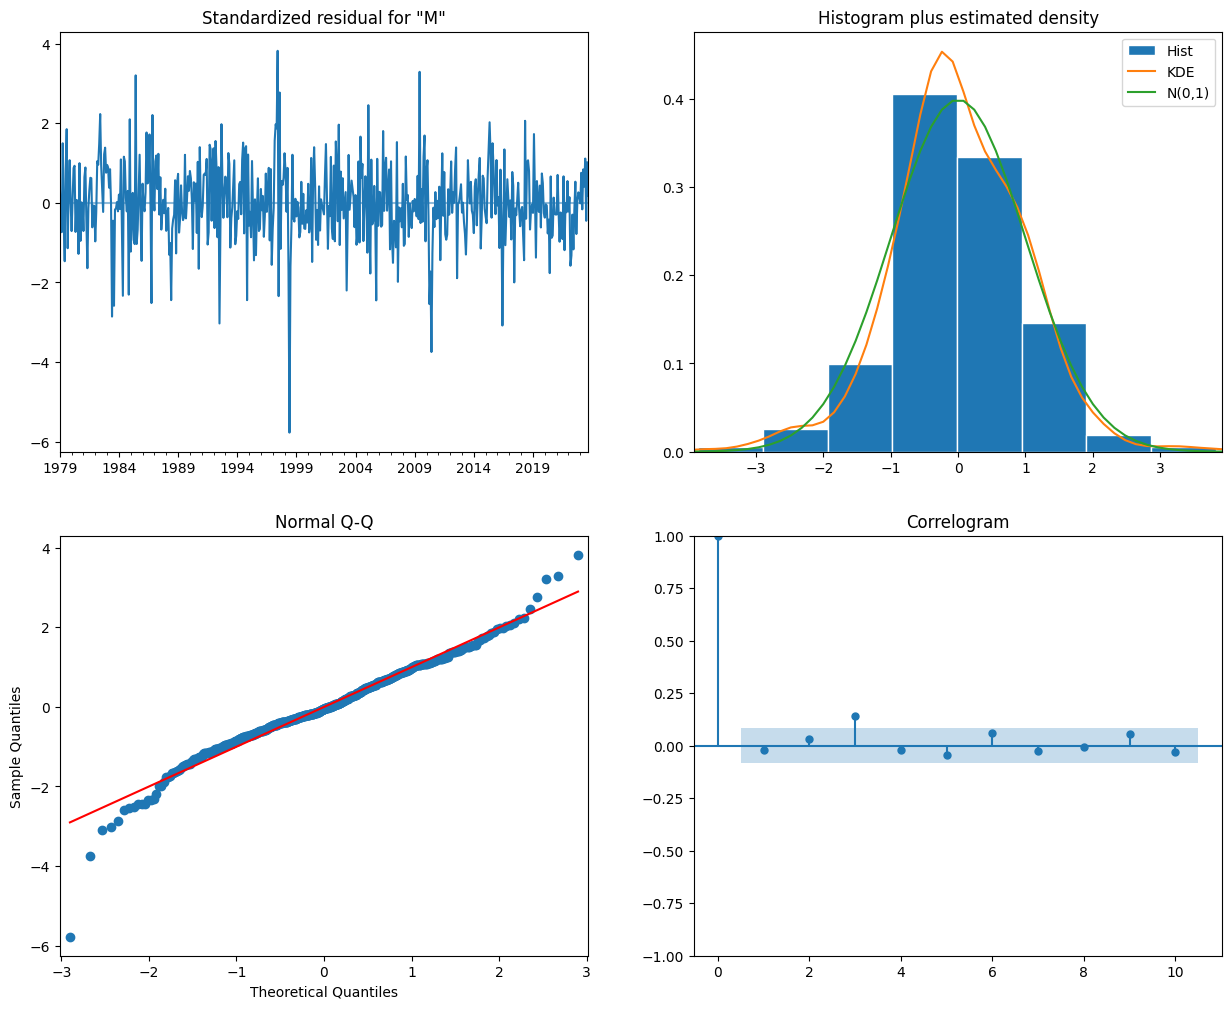

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -59.222
Date:                Wed, 08 Nov 2023   AIC                            126.444
Time:                        18:03:50   BIC                            143.588
Sample:                    01-01-1979   HQIC                           133.150
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0451      0.206     -0.218      0.827      -0.450       0.359
ar.L1          0.9075      0.018     50.042      0.000       0.872       0.943
ma.L1          0.5567      0.032     17.473      0.000       0.494       0.619
sigma2         0.0726      0.003     22.969      0.000       0.066       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               179.89
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.38
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [246]:
# Fit an ARIMA(2,0,2) model
arima_model_202 = ARIMA(enso_df['MEI'], order=(2, 0, 2))
arima_result_202 = arima_model_202.fit()

# Plot the diagnostics for the ARIMA(1,0,1) model
fig = arima_result_101.plot_diagnostics(figsize=(15, 12))
plt.show()

# Return the summary of the new model as well
arima_result_101_summary = arima_result_101.summary()
display(arima_result_101_summary)

- ARIMA(2,0,2) seems to be the best fitting model
- However followign parsimony we will choose the ARIMA(1,0,1) model since the improvements over this model do not seem to be good enough

### ARIMAX(1,0,1) Continuation

We will now combine this model with a exogenous Fourier Decomposed variables to hopefully improve fit and add seasonality to our model.

- Add the seasonal Fourier components to the ARIMA(1,0,1) model as exogenous variables.
- Fit the ARIMAX model to the MEI time series data.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84357D-02    |proj g|=  1.77493D-01

At iterate    5    f=  4.76626D-02    |proj g|=  2.38143D-02

At iterate   10    f=  4.72812D-02    |proj g|=  1.19682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   1.143D-05   4.728D-02
  F =   4.7281234783005818E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


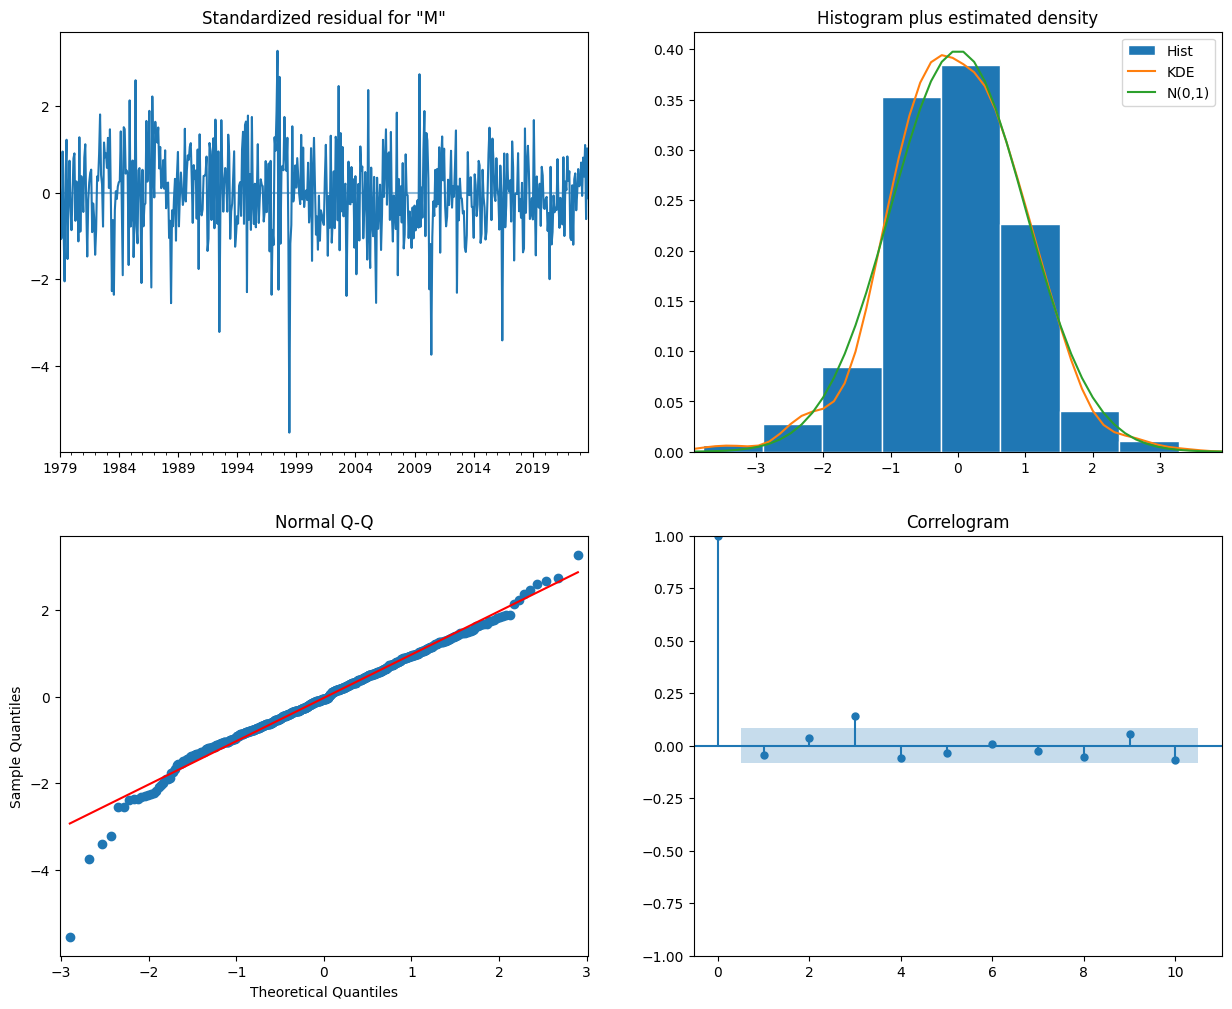

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -25.390
Date:                Wed, 08 Nov 2023   AIC                             58.780
Time:                        18:14:21   BIC                             75.924
Sample:                    01-01-1979   HQIC                            65.487
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9996      0.099     10.066      0.000       0.805       1.194
ar.L1          0.8075      0.026     30.695      0.000       0.756       0.859
ma.L1          0.6392      0.032     19.918      0.000       0.576       0.702
sigma2         0.0641      0.003     21.474      0.000       0.058       0.070
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):               102.79
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.42
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [255]:
# Fit an ARIMAX model using the ARIMA(1,0,1) specification with the seasonal components
arimax_model = SARIMAX(enso_df['MEI'], exog=reconstructed_series, order=(1, 0, 1))
arimax_result = arimax_model.fit()

# Plot the diagnostics for the ARIMAX model
fig = arimax_result.plot_diagnostics(figsize=(15, 12)) # type: ignore
plt.savefig('../Plots/ARIMA_101_ex.png')
plt.show()

# Return the summary of the ARIMAX model as well
arimax_result_summary = arimax_result.summary() # type: ignore
display(arimax_result_summary)


ARIMAX(1,0,1) 
- AR and MA terms are significant
- Fourier components significant besides a couple
- LL improved from -36 to -58 compared to non exogenous ARIMA
- AIC/BIC lowered to 58 and 75
- L-B test no significant autocorrelation
- J-B test indicates that residuals are still not normally distributed but improvement over previous models
- ACF seems stable
- QQ shows still heavier tails.


### GARCH

A GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model can be a valuable addition when there is evidence of conditional heteroskedasticity — that is, when the volatility (variance of the residuals) changes over time in a predictable pattern. It is particularly useful for financial time series where volatility clustering is common.

For the MEI.v2 time series, which is an environmental/climatic index, the use of a GARCH model is less common. However, if there is a reason to believe that there are volatility patterns in the MEI.v2 data that a GARCH model could capture, it might be worth exploring.

Before deciding to fit a GARCH model, we should look for signs of conditional heteroskedasticity in the residuals of the ARIMAX model. If we observe patterns or clusters of high and low volatility, a GARCH model could potentially improve the model by capturing this aspect of the data.

From the ARIMAX diagnostics, the residuals did not show clear signs of conditional heteroskedasticity, as the correlogram of squared standardized residuals did not indicate significant autocorrelations. This suggests that a GARCH model may not be necessary. Additionally, the p-value for the heteroskedasticity test was above 0.05, indicating no strong evidence of heteroskedasticity.

However, if you would like to test whether a GARCH model can improve the normality of the residuals, we can fit a GARCH(1,1) model to the residuals of the ARIMAX model and evaluate the results.

Would you like to proceed with fitting a GARCH model to the residuals?

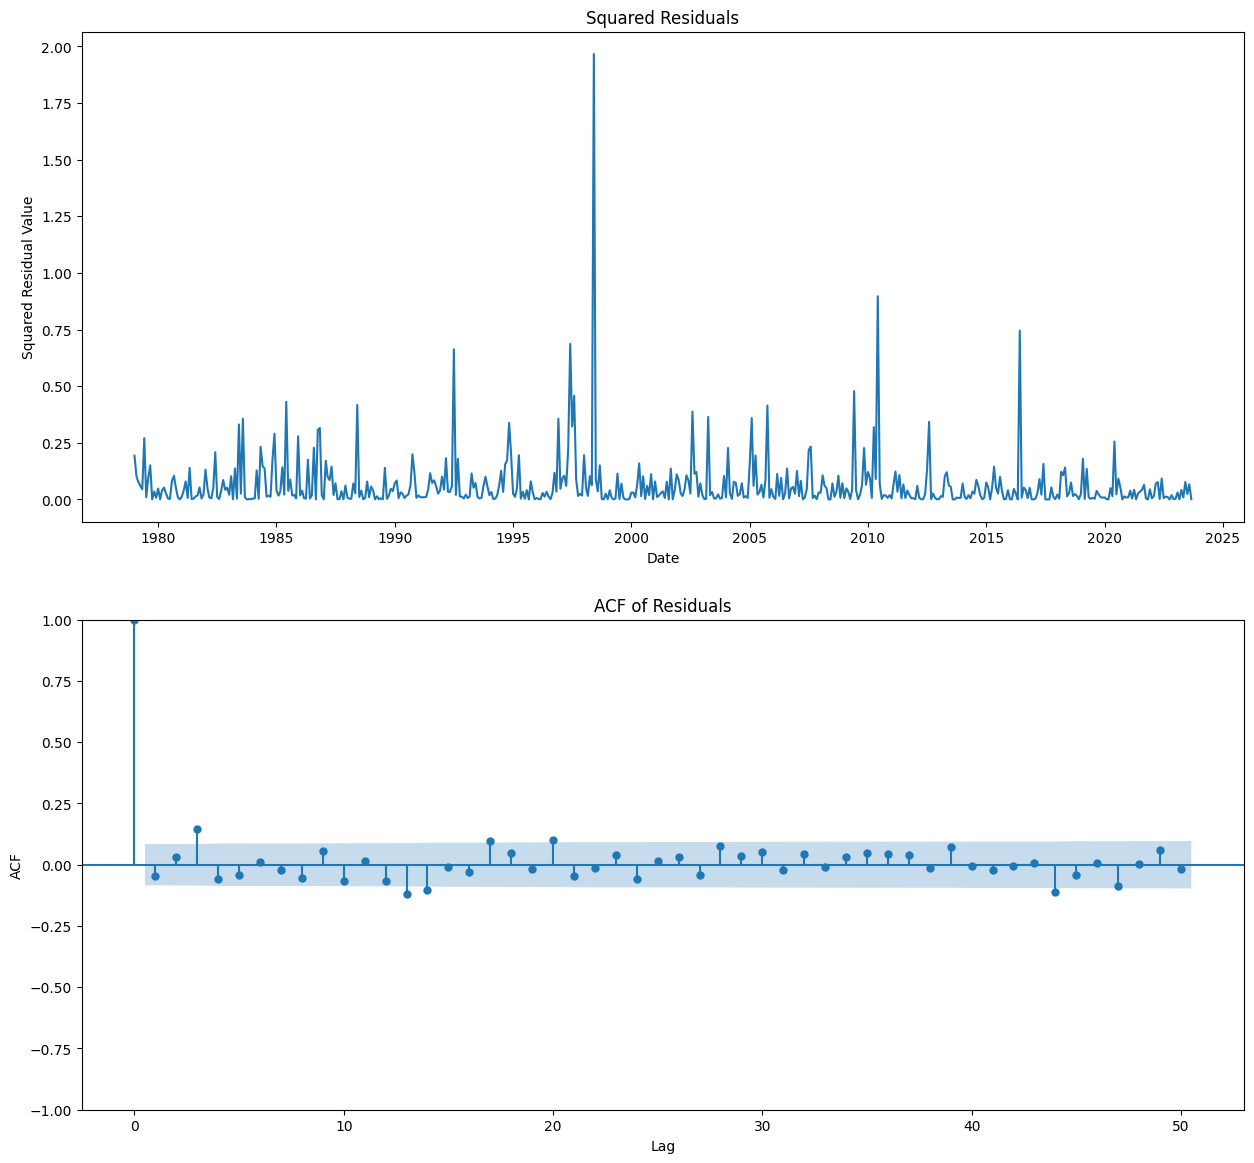

(39.509685077064916, 0.803582252503346, 0.8057395258194218, 0.8203765449349426)

In [272]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# Perform Ljung-Box test on the residuals
ljung_box_result_resid = acorr_ljungbox(arimax_result.resid, lags=[10], return_df=True)

# Perform Ljung-Box test on the squared residuals
ljung_box_result_squared_resid = acorr_ljungbox(arimax_result.resid**2, lags=[10], return_df=True)

# Perform Engle's ARCH test on the residuals
arch_test = het_arch(arimax_result.resid, nlags=12*4)

# Create a rolling standard deviation plot for the residuals (volatility plot)
# rolling_window = 50  # Rolling window size
# rolling_std_resid = pd.Series(arimax_result.resid).rolling(window=rolling_window).std()

fig, axes = plt.subplots(2, 1, figsize=(15, 14))

# Plot the squared residuals
axes[0].plot(arimax_result.resid ** 2)
axes[0].set_title('Squared Residuals')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Squared Residual Value')

# Plot ACF of residuals
plot_acf(arimax_result.resid, lags=50, ax=axes[1])
axes[1].set_title('ACF of Residuals')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('ACF')

plt.savefig('../Plots/ARIMA_101_ex_resid.png')
plt.show()
# Output the test results
arch_test

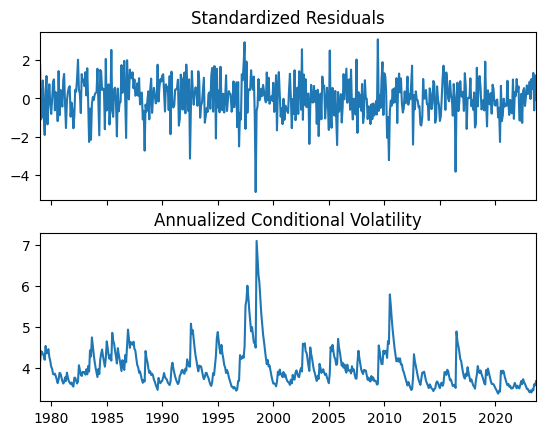

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/univariate/base.py:1894: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/univariate/base.py:1895: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/univariate/base.py:1896: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -20.3175
Distribution:                  Normal   AIC:                           48.6350
Method:            Maximum Likelihood   BIC:                           65.7790
                                        No. Observations:                  537
Date:                Wed, Nov 08 2023   Df Residuals:                      536
Time:                        18:23:51   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0130  1.227e-02     -1.060      0.289 [-3.706e-02,1.105e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.8527e-03  7.829e-03      0.875      0.381 [-8.492e-03,2.220e-02]
alpha[1]       0.0656  3.669e-02      1.788  7.372e-02   [-6.296e-03,  0.138]
beta[1]        0.8279      0.144      5.752  8.821e-09      [  0.546,  1.110]
=============================================================================

Covariance estimator: robust
"""

Text(0.5, 1.0, 'Squared Residuals')

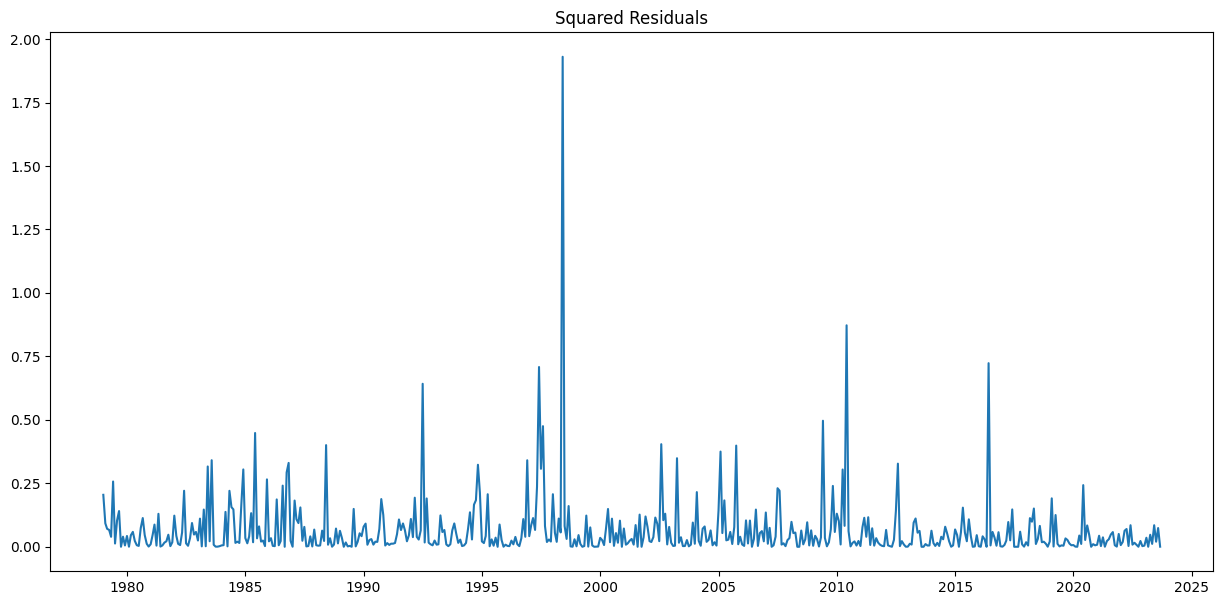

In [266]:
from arch import arch_model

# Extract the residuals from the ARIMAX model
arimax_residuals = arimax_result.resid

# Fit a GARCH(1,1) model to the residuals of the ARIMAX model
garch_model = arch_model(arimax_residuals, vol='Garch', p=1, q=1, rescale=False)
garch_result = garch_model.fit(update_freq=0, disp='off')

# Plot the GARCH model diagnostics
fig = garch_result.plot(annualize='D')
plt.show()

# Return the summary of the GARCH model as well
garch_result_summary = garch_result.summary()
display(garch_result_summary)

#Plot squared residuals
plt.figure(figsize=(15, 7))
plt.plot(garch_result.resid ** 2)
plt.title('Squared Residuals')

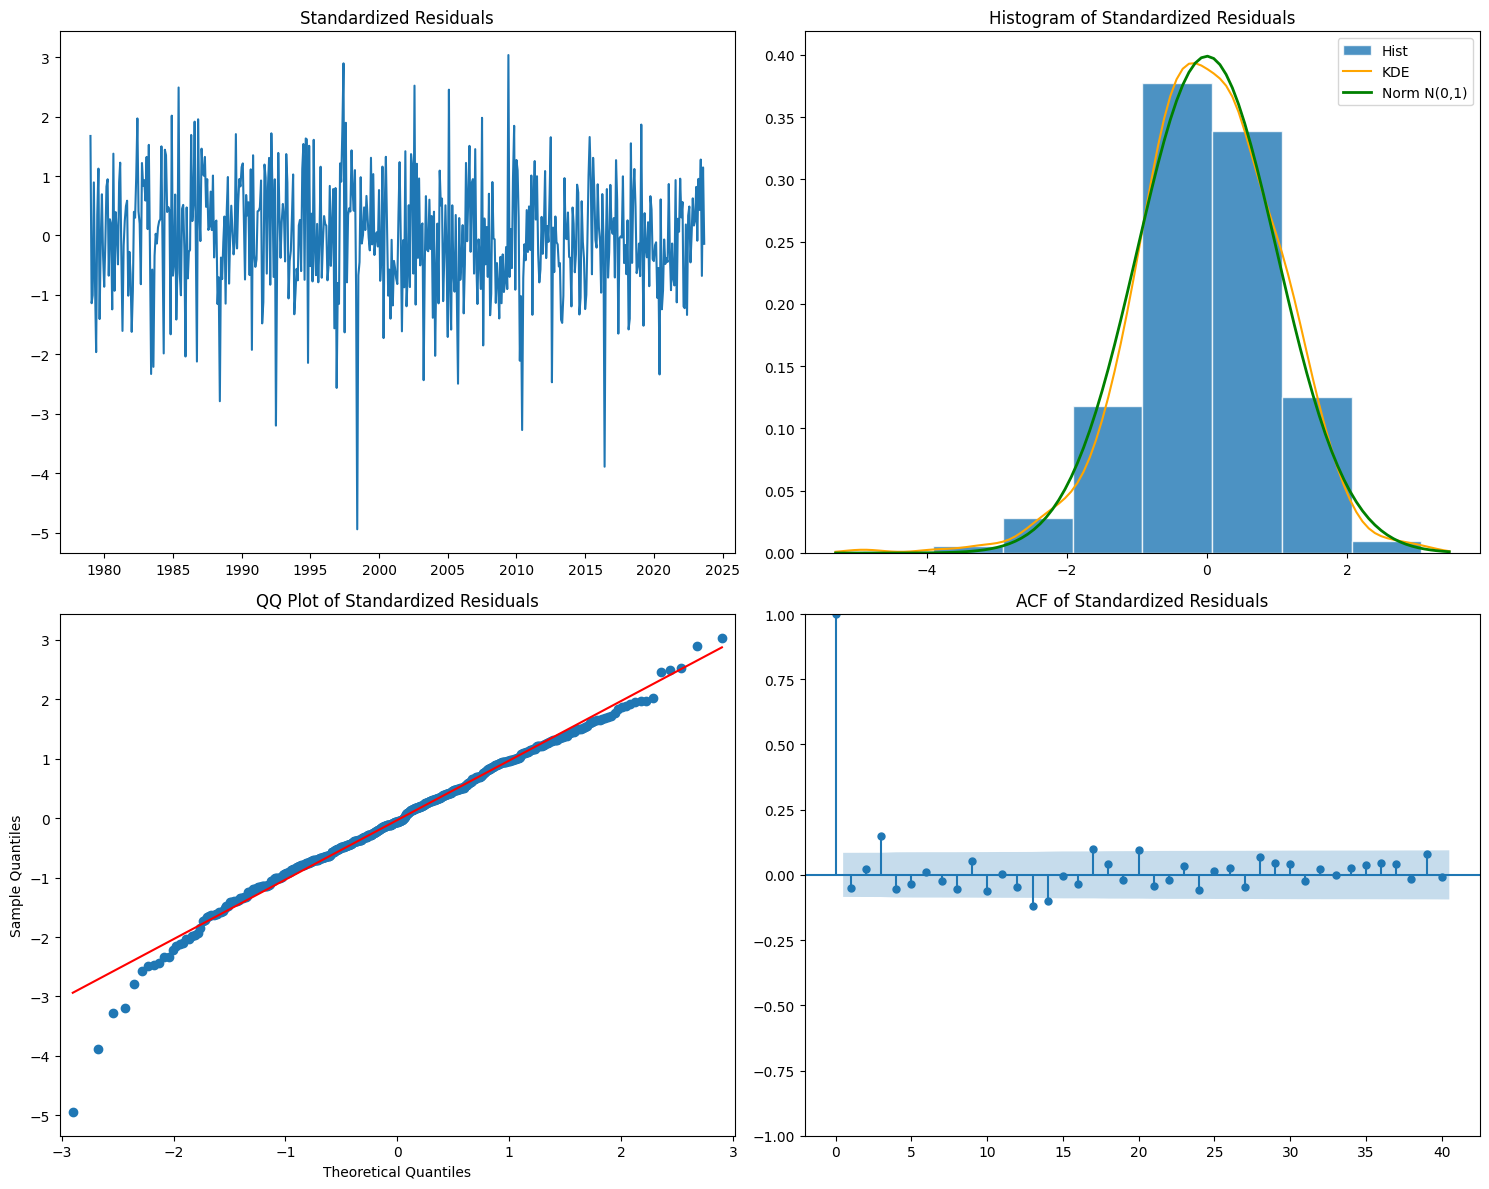

In [220]:
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import gaussian_kde


# Standardize the residuals
standardized_residuals = arimax_residuals / garch_result.conditional_volatility

# Normalized residuals for the histogram
normalized_residuals = (standardized_residuals - np.mean(standardized_residuals)) / np.std(standardized_residuals)
num_bins = 8

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot standardized residuals
axs[0, 0].plot(standardized_residuals)
axs[0, 0].set_title('Standardized Residuals')


# Histogram of the standardized residuals with KDE
axs[0, 1].hist(normalized_residuals, bins=num_bins, density=True, alpha=0.8, label='Hist', linewidth= 1, edgecolor='white')
# Kernel Density Estimate (KDE) plot
kde = gaussian_kde(normalized_residuals)
x_grid = np.linspace(xmin, xmax, 100)
kde_pdf = kde(x_grid)
axs[0, 1].plot(x_grid, kde_pdf, '-', label='KDE', color = 'orange')
# Best fit line for normal distribution
p = norm.pdf(x_grid, np.mean(normalized_residuals), np.std(normalized_residuals))
axs[0, 1].plot(x_grid, p, '-', linewidth=2, color = 'green',label='Norm N(0,1)')
axs[0, 1].set_title('Histogram of Standardized Residuals')
axs[0, 1].legend()

# QQ plot for standardized residuals
qqplot(standardized_residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('QQ Plot of Standardized Residuals')

# ACF plot for standardized residuals
plot_acf(standardized_residuals, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('ACF of Standardized Residuals')


plt.tight_layout()
plt.show()

## Forecasting (No GARCH)

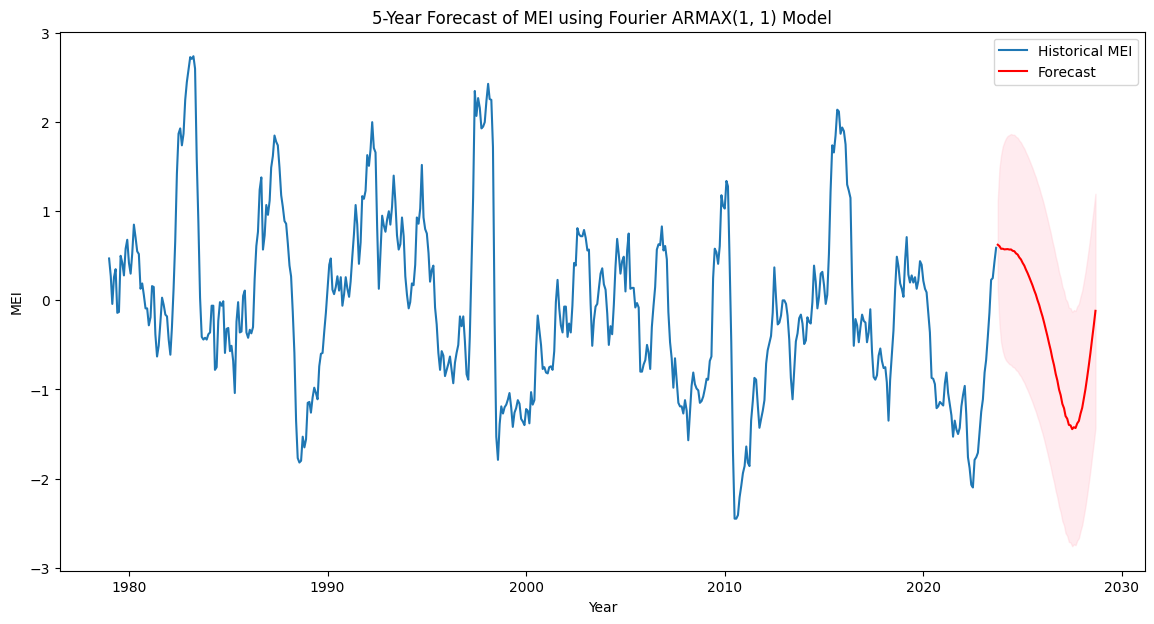

In [366]:
# Forecast the next 5 years (60 months) using the ARIMAX model
forecast_steps = 60  # 5 years * 12 months per year
forecast = arimax_result.get_forecast(steps=forecast_steps, exog=reconstructed_series[-forecast_steps:])

# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the historical MEI data along with the forecast and confidence intervals
plt.figure(figsize=(14, 7))

# Plot the historical data
plt.plot(enso_df['MEI'], label='Historical MEI')

# Plot the forecasted data
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('5-Year Forecast of MEI using Fourier ARMAX(1, 1) Model')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.savefig('../Plots/ARIMA_101_ex_forecast.png')
plt.show()


ARIMAX

The red line represents the forecasted MEI values.
The pink shaded area indicates the 95% confidence intervals for the forecast.

### GARCH Forecast (not used)

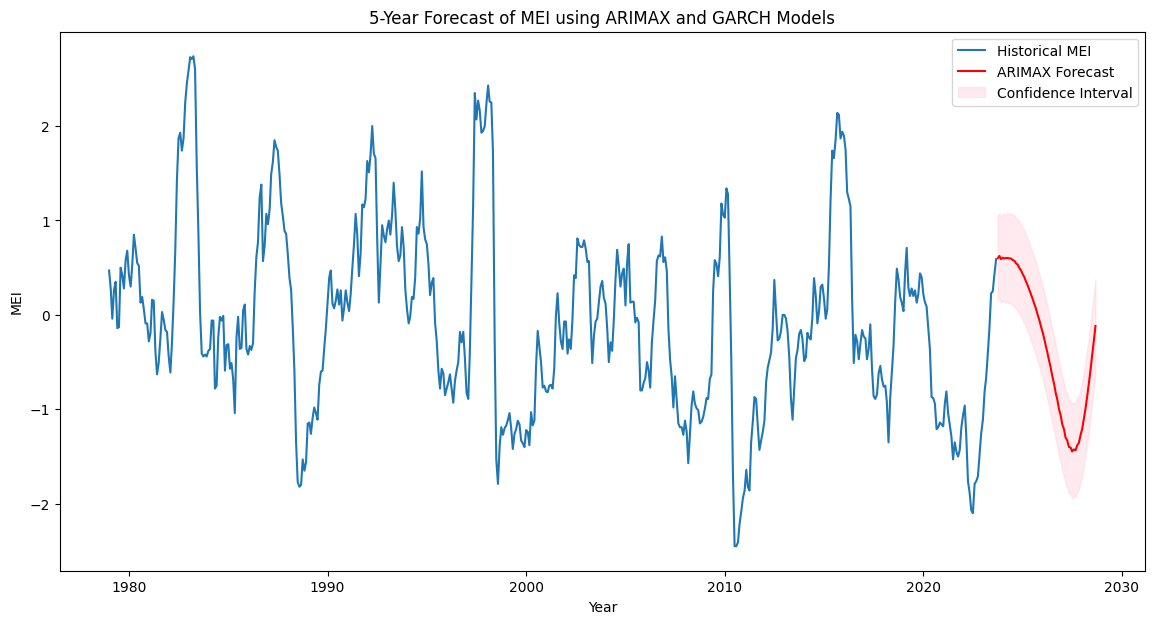

In [229]:
from scipy.stats import norm

# Forecast the next 5 years (60 months) using the ARIMAX model
forecast_steps = 60  # 5 years * 12 months per year
forecast = arimax_result.get_forecast(steps=forecast_steps, exog=reconstructed_series[-forecast_steps:])

# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

#GARCH forecast
garch_forecast = garch_result.forecast(horizon=forecast_steps, reindex = False)
forecast_volatility = np.sqrt(garch_forecast.variance.dropna().values[-1])

z_score = norm.ppf(0.975)

forecast_lower = forecast_mean - (z_score * forecast_volatility)
forecast_upper = forecast_mean + (z_score * forecast_volatility)


# Plot the historical MEI data along with the forecast and confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(enso_df['MEI'], label='Historical MEI')
plt.plot(forecast_mean.index, forecast_mean, label='ARIMAX Forecast', color='red')
plt.fill_between(forecast_mean.index, forecast_lower, forecast_upper, color='pink', alpha=0.3, label='Confidence Interval')
plt.title('5-Year Forecast of MEI using ARIMAX and GARCH Models')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.show()


ARIMAX-GARCH

The red line represents the forecasted MEI values.
The pink shaded area indicates the 95% confidence intervals for the forecast.

### Phase Scenario's

Simulate different phases using forecasted values as baseline.

- Heavier -> increase by a certain percentage or add constant
- Longer -> Extend duration of positive values before going back to La Niña
   - To add realism we incorporate a random variation to the forecasts


### Heavier

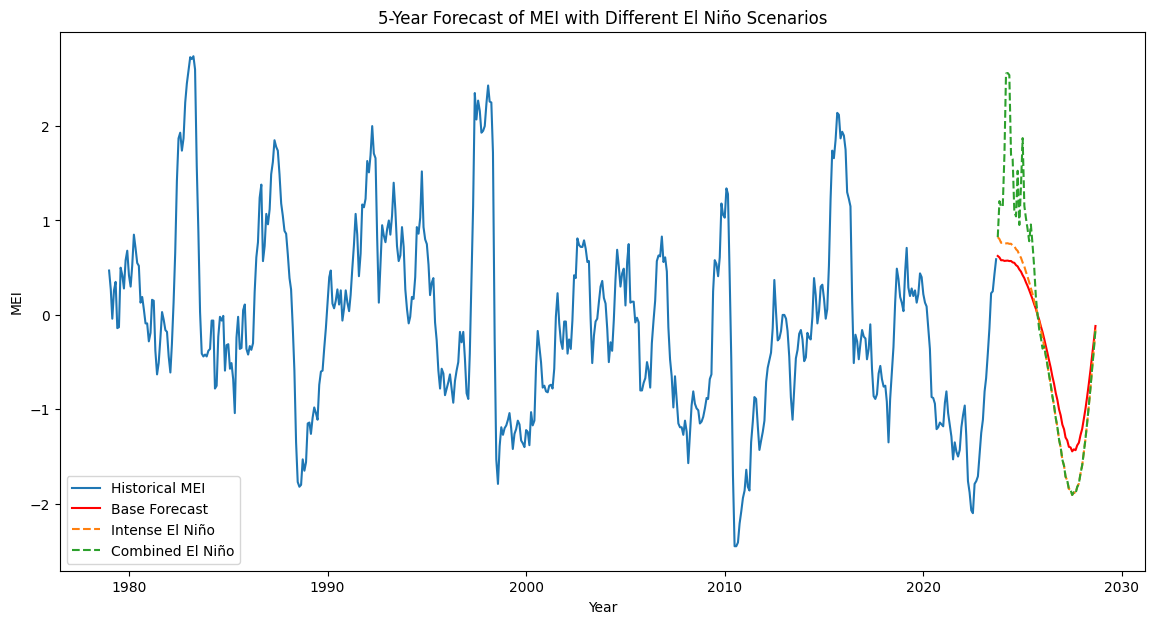

In [367]:
import random
#set seed
random.seed(42)
# Define the parameters for the scenarios
intensity_factor = 1.5  # Increase intensity by 50%
duration_extension = 6  # Extend the phase by 6 months

# Create a DataFrame to hold the scenarios
scenarios_df = pd.DataFrame(index=forecast_mean.index)

# Scenario 1: Intense El Niño
scenarios_df['Intense El Niño'] = forecast_mean * (1 + random.uniform(0, intensity_factor - 1))

# Scenario 2: Long El Niño

# Scenario 3: Combination of intense and long El Niño
scenarios_df['Combined El Niño'] = scenarios_df['Intense El Niño'].copy()
for i in range(len(scenarios_df['Combined El Niño']) - duration_extension):
    if scenarios_df['Combined El Niño'].iloc[i] > 0:  # If we're in an El Niño phase
        extension = random.uniform(0, duration_extension)
        scenarios_df['Combined El Niño'].iloc[i:i+int(extension)] *= intensity_factor


# Plot the scenarios alongside the historical data and the base forecast
plt.figure(figsize=(14, 7))

# Plot the historical data
plt.plot(enso_df['MEI'], label='Historical MEI')

# Plot the base forecasted data
plt.plot(forecast_mean.index, forecast_mean, label='Base Forecast', color='red')

# Plot the scenarios
plt.plot(scenarios_df.index, scenarios_df['Intense El Niño'], label='Intense El Niño', linestyle='--')
# plt.plot(scenarios_df.index, scenarios_df['Long El Niño'], label='Long El Niño', linestyle='--')
plt.plot(scenarios_df.index, scenarios_df['Combined El Niño'], label='Combined El Niño', linestyle='--')

plt.title('5-Year Forecast of MEI with Different El Niño Scenarios')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.show()


The scenarios are generated with some randomness to reflect natural variability, and as you can see, they vary in terms of both intensity and duration compared to the base forecast.

These simulations provide a visual representation of how future El Niño events could differ from the typical patterns observed in the past, assuming various changes in intensity and duration. Keep in mind that actual future conditions may be influenced by many other factors not included in this model.​

### Combined Scenario's (This will be used)

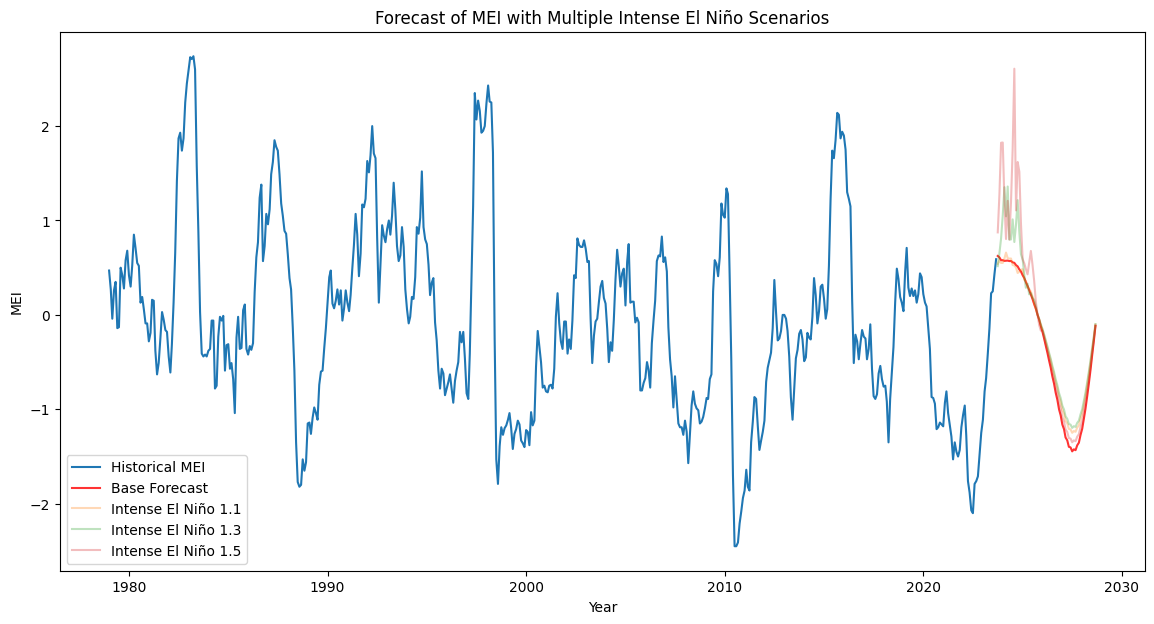

In [364]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set the random seed for reproducibility
random.seed(42)

# Define the range of intensity factors
intensity_factors = [1.1, 1.3, 1.5]

# Create a DataFrame to hold the scenarios
scenarios_df = pd.DataFrame(index=forecast_mean.index)

# Generate scenarios with increasing intensity factors
for factor in intensity_factors:
    scenario_name = f"Intense El Niño {factor}"
    scenarios_df[scenario_name] = forecast_mean * (0.8 + random.uniform(0, factor - 1))
    for i in range(len(scenarios_df[scenario_name]) - duration_extension):
        if scenarios_df[scenario_name].iloc[i] > 0:
            extension = random.uniform(0, duration_extension)
            scenarios_df[scenario_name].iloc[i:i+int(extension)] *= factor


# Plot the historical data and the base forecast
plt.figure(figsize=(14, 7))
plt.plot(enso_df['MEI'], label='Historical MEI')
plt.plot(forecast_mean.index, forecast_mean, label='Base Forecast', color='red', alpha = 0.8)

# Plot each of the intense El Niño scenarios
for column in scenarios_df.columns:
    plt.plot(scenarios_df.index, scenarios_df[column], label=column, linestyle='-', alpha = 0.3)

# Add title, labels, and legend
plt.title('Forecast of MEI with Multiple Intense El Niño Scenarios')
plt.xlabel('Year')
plt.ylabel('MEI')
plt.legend()
plt.show()


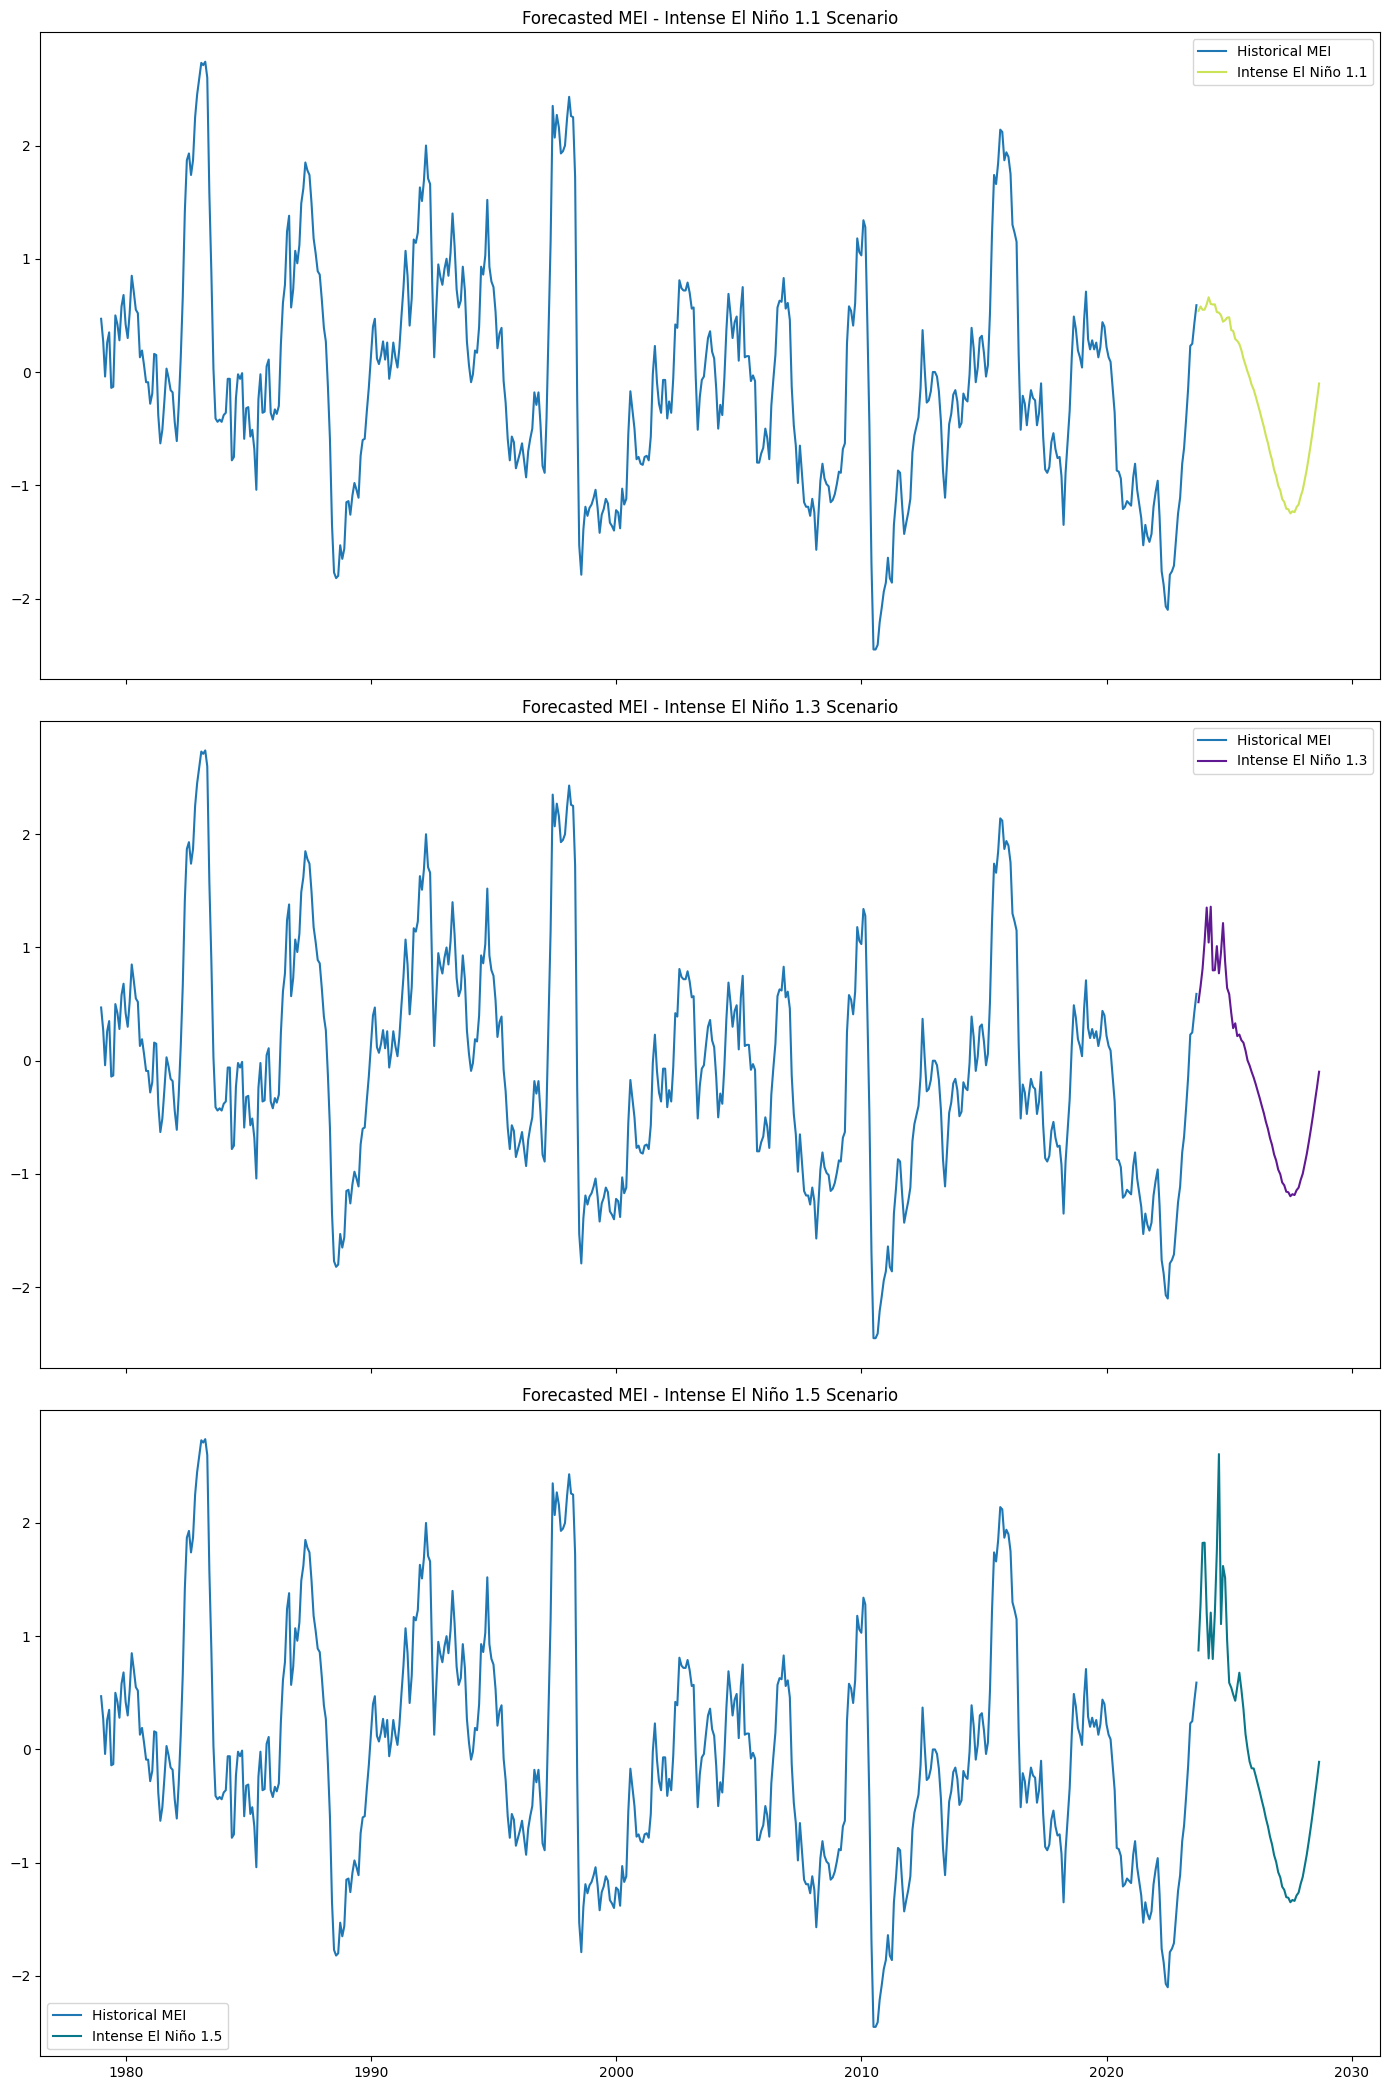

In [359]:
fig, axs = plt.subplots(len(scenarios_df.columns), 1, figsize=(14, 7 * (len(scenarios_df.columns))), sharex=True)

# Plot each scenario
for i, column in enumerate(scenarios_df.columns, start=0):
    axs[i].plot(enso_df.index, enso_df['MEI'], label='Historical MEI')
    axs[i].plot(scenarios_df.index, scenarios_df[column], label=column, color=np.random.rand(3,))
    axs[i].set_title(f'Forecasted MEI - {column} Scenario')
    axs[i].legend()

plt.tight_layout()
plt.show()

### Try Brownian Moition (Not Used)

In [347]:
def generate_brownian_scenarios(base_forecast, drift_rate, volatility, num_scenarios=1):
    scenarios_df = pd.DataFrame(index=base_forecast.index)
    for i in range(num_scenarios):
        scenario = base_forecast.copy()     
        # Apply Brownian motion
        for t in range(1, len(scenario)):
            drift = drift_rate[i] * scenario.iloc[t - 1]
            shock = np.random.normal(0, volatility)
            scenario.iloc[t] = scenario.iloc[t] + drift + shock
    
        scenarios_df[f'Scenario_{i + 1}'] = scenario
    
    return scenarios_df
volatility = 1
drift_rate = [0.2, 0.3, 0.4]
num_scenarios = 3 
scenarios_df = generate_brownian_scenarios(forecast_mean, drift_rate, volatility, num_scenarios)


## Save predictions/scenario's/simulations

In [368]:
#Extract Predicted values
forecast_dates = forecast_mean.index
forecast_values = forecast_mean.values


# Create a dictionary to hold dates and values for each scenario
scenarios_data = {}

for scenario in scenarios_df.columns:
    # Extract the MEI values for the scenario
    scenario_values = scenarios_df[scenario].values
    # Store the dates and values in the dictionary
    scenarios_data[scenario] = {
        'dates': forecast_dates,
        'values': scenario_values
    }

In [369]:
pd.DataFrame(forecast_dates, forecast_values).head()

,0
0.624318,2023-10-01
0.608857,2023-11-01
0.578867,2023-12-01
0.579546,2024-01-01
0.572073,2024-02-01
